<a href="https://colab.research.google.com/github/KimRass/Programming/blob/master/Data%20Science/Machine%20Learning/Time%20Series/NYC%20Taxi%20%26%20TadGAN%20(Anomaly%20Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data Science/Machine Learning/Time Series/NYC Taxi & TadGAN (Anomaly Detection).ipynb
!pip uninstall -y keras-nightly tensorflow
!pip install orion-ml 'urllib3>=1.25.4,<1.26'

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0


### Remember to restart runtime!

Let's view the installed Orion version

In [ ]:
! pip freeze | grep orion-ml

orion-ml==0.2.0


To properly run the Tulog, we require some supporting files.

In [ ]:
%%bash
rm -rf Orion
rm -rf images

git clone https://github.com/signals-dev/Orion.git
mv Orion/tutorials/tulog/* .
exit

Cloning into 'Orion'...


In [ ]:
# https://analyticsindiamag.com/hands-on-guide-to-tadgan-with-python-codes/ 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from orion import Orion
from orion.data import load_signal, load_anomalies
from orion.primitives.tadgan import TadGAN
from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts
from model import hyperparameters

plt.style.use("dark_background")

ModuleNotFoundError: ignored

In [ ]:
signal = "nyc_taxi"
raw_data = load_signal(signal)
known_anoms = load_anomalies(signal)

In [ ]:
known_anoms

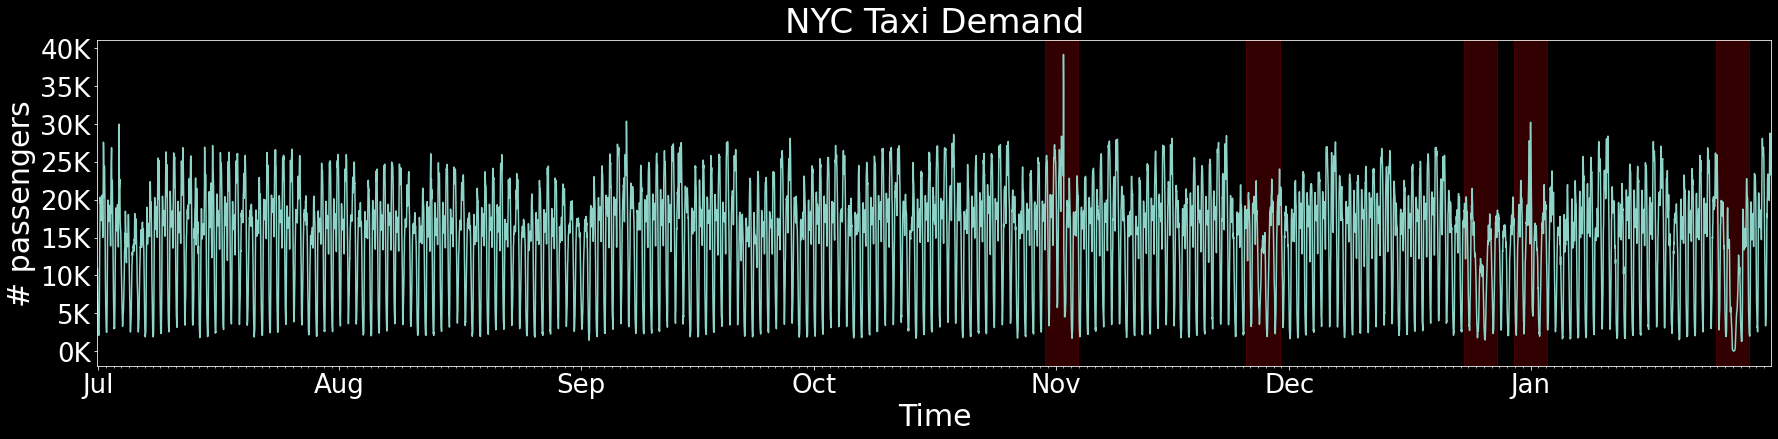

In [ ]:
# This function plots time series and highlights anomalous regions.
# The first anomaly in `anomalies` is considered the ground truth.
plot(raw_data, anomalies=known_anoms);

In [ ]:
# The model is specified in `tadgan.json`.
orion = Orion(pipeline="tadgan.json")
# To train the model on the data, we simply use the `orion.fit()` method.
# To do anomaly detection, we use the `orion.detect()` method.
# In our case, we want to fit the data and then perform detection; therefore we use the `orion.fit_detect()` method.
Note: the model might take some time to train. For experimentation purposes, you can reduce the number of epochs in the tadgan.json file such that you reduce the number of training iterations.
detected_anoms = orion.fit_detect(raw_data)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1/5, [Dx loss: [-0.63344276 -3.1252823   1.6579944   0.08338454]] [Dz loss: [-4.067793    0.07496607 -5.5632544   0.14204952]] [G loss: [12.225551   -1.6539485  12.265947    0.16135532]]
Epoch: 2/5, [Dx loss: [-1.0800598  -7.5220547   6.2536287   0.01883645]] [Dz loss: [-36.36307      0.54905087 -39.0068       0.20946838]] [G loss: [54.673054   -6.267595   59.509026    0.14316222]]
Epoch: 3/5, [Dx loss: [-0.93382096 -8.550386    7.430653    0.01859155]] [Dz loss: [-197.74974      1.8626999 -206.928        0.7315568]] [G loss: [ 2.3062453e+02 -7.5672984e+00  2.3686966e+02  1.3221921e-01]]
Epoch: 4/5, [Dx loss: [-0.73137367 -9.560253    8.652884    0.01759955]] [Dz loss: [-115.89896      2.5474608 -136.95702      1.8510615]] [G loss: [145.01135     -7.9494123  151.26395      0.16968343]]
Epoch: 5/5, [Dx loss: [-0.92864233 -0.09587204 -1.0752138   0.02424435]] [Dz loss: [ 1.6403346   2.8372083  -5.499761    0.43028885]] [G loss: [8.8257675  0.885256   6.038376   0.19021362]]


In [ ]:
detected_anoms

,start,end,severity
0,1404165600,1404280800,0.149149
1,1404428400,1404885600,0.828335
2,1408840200,1409124600,0.593600
3,1409358600,1409722200,0.382605
4,1414618200,1414996200,0.328997
5,1417125600,1417408200,1.002909
6,1419285600,1419762600,0.812990
7,1422153000,1422504000,0.329840


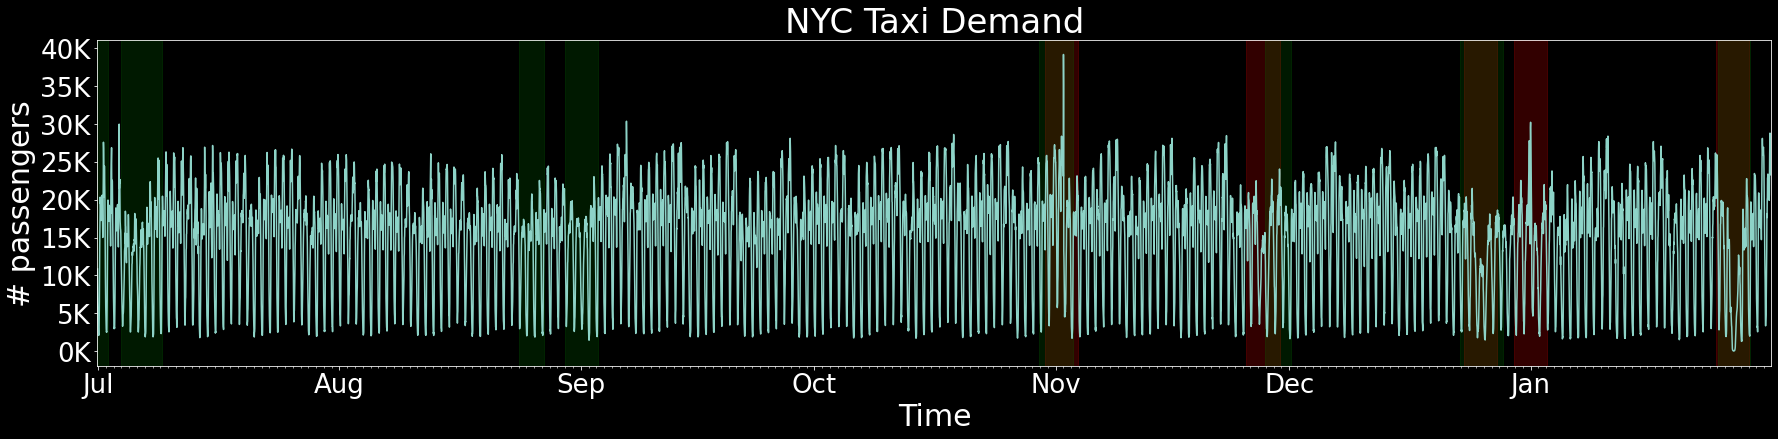

In [ ]:
plot(df, anomalies=[known_anoms, detected_anoms])

In [ ]:
# `interval`: An interger that refers to the time span to compute aggregation of.
# `time_column`: Column of `X` that contains time values.
# `method`: What aggregation method should be used to compute the value, by default this set to the mean.
def time_segments_aggregate(X, interval, time_column, method=["mean"]):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(raw_data, interval=1800, time_column="timestamp")

In [ ]:
X

array([[10844.],
       [ 8127.],
       [ 6210.],
       ...,
       [27309.],
       [26591.],
       [26288.]])

If we go back to the source of the NYC Taxi data, we find that it records a value each 30 minutes. In the timestamp world, this is equivalent to 1800 seconds, therefore we set the interval to be `1800`. We also opt for the default aggregation method which is taking the `mean` value of each interval.

Technically speaking, in our example the data is perfectly spaced, so we can skip this preprocessing step. However, that is not always the case and so we include it as a preprocessing primitive in the general pipeline as you will see later on.

#### B. data imputation

impute missing values that appear within the signal using scikit-learn's `SimpleImputer` which fills missing values by the mean value.

In [ ]:
imp = SimpleImputer()
X = imp.fit_transform(X)

#### C. data normalization 
normalize the data between a specific range, we use scikit-learn's `MinMaxScaler` to scale data between [-1, 1].

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

Notice how the y-axis changed after normalizing the data between [-1, 1]

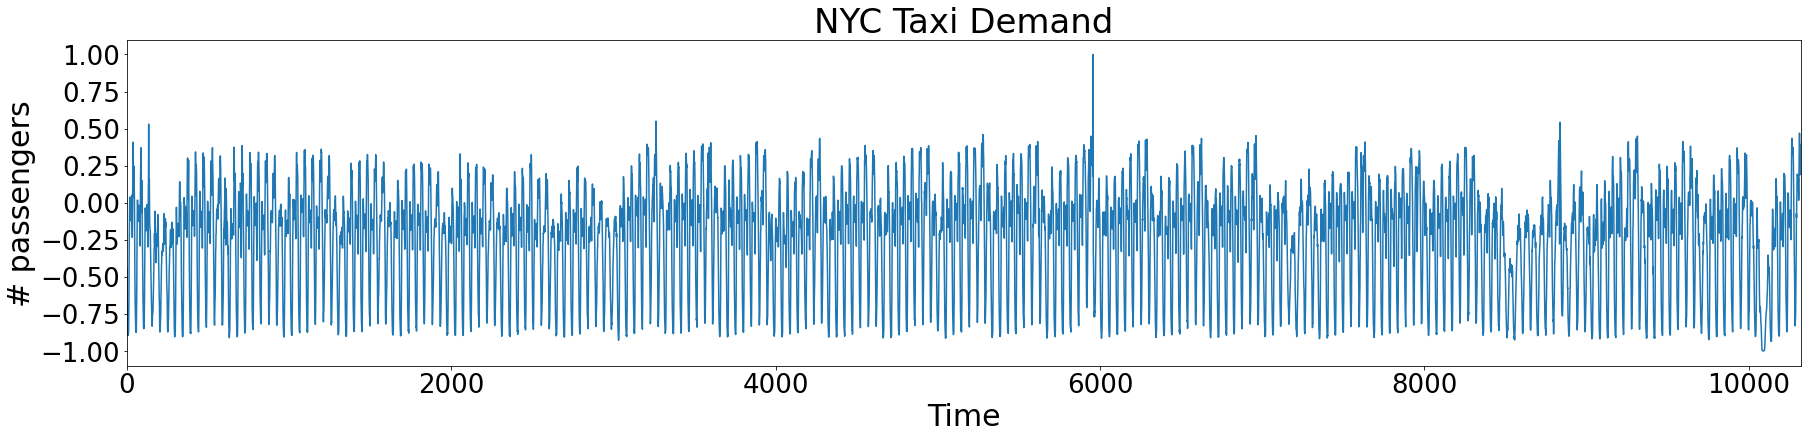

In [ ]:
plot_ts(X)

#### D. slice the data to rolling window
to prepare the data, we need to transform it into a sequence that is ingestable by the machine learning model. 
We take the signal we're interested in analyzing and we generate training examples. These training examples are mere snapshots of signal at different times.

In order to do that, we adopt the sliding window approach of choosing a window of a pre-specified width and a particular step size. Once that's been decided we divide the signal indo segments, similar to what is depicited in the illustration below.

<img src="https://github.com/signals-dev/Orion/blob/master/notebooks/tulog/images/sliding_window.png?raw=1" alt="Drawing" width="400"/>

We create a `rolling_window_sequence` function that slices the data into parts, each part contains:
- the target value; the value at time t.
- previous observed values, this is determined by the window width.

In [ ]:
# Window로 쪼개기 = Blocked Validation.
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [ ]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (10222, 100, 1)
Training data index shape: (10222,)
Training y shape: (10222, 1)
Training y index shape: (10222,)


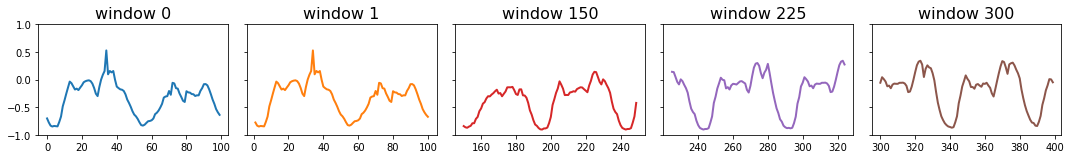

In [ ]:
plot_rws(X)

Where `X` represents the input used to train the model. In the previous example, we see `X` has `10222` training data points. Notice that `100` represents the window size. On the other hand, `y` is the real signal after processing, which we will use later on to calculate the error between the reconstructed and real signal. 


### Pipeline Training and Detection

The architecture of the model requires four neural networks:
- `encoder`: maps `X` to its latent representation `Z`.
- `generator`: maps the latent variable `Z` back to `X`, which we will denote later on as `X_hat`.
- `criticX`: discriminates between `X` and `generator(Z)` or `X_hat`.
- `criticZ`: discriminates between `Z` and `encoder(X)`.

we detail the composition of each network in `model.py`.

To use the `TadGAN` model, we specify a number of parameters including the model layers (structure of the previously mentioned neural networks). We also specify the input dimensions, the number of epochs, the learning rate, etc. All the parameters are listed below.

In [ ]:
hyperparameters["epochs"] = 100
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected

Epoch: 1/100, [Dx loss: [-0.7957388  -6.619936    5.1338534   0.06903441]] [Dz loss: [-1.250552   -1.2141291  -1.3405024   0.13040808]] [G loss: [-1.7248876  -5.1170483   2.0652776   0.13268833]]
Epoch: 2/100, [Dx loss: [-0.5355328  -6.8586      6.192504    0.01305664]] [Dz loss: [-2.4891894  -1.6969012  -1.7012362   0.09089479]] [G loss: [-2.7290456  -6.199571    2.2762792   0.11942458]]
Epoch: 3/100, [Dx loss: [ -0.5440234  -10.943925    10.2609625    0.01389375]] [Dz loss: [-1.4871325  -1.1520628  -0.7888213   0.04537519]] [G loss: [ -8.246571  -10.272019    1.2702218   0.0755228]]
Epoch: 4/100, [Dx loss: [-0.27064613 -9.638172    9.242068    0.01254534]] [Dz loss: [-6.9235557e-01 -6.4558483e-04 -1.1623843e+00  4.7067445e-02]] [G loss: [-6.6016746  -9.207315    1.8266237   0.07790164]]
Epoch: 5/100, [Dx loss: [-0.58065754 -9.967931    9.283531    0.01037437]] [Dz loss: [-1.3110168   2.8955936  -5.2277436   0.10211328]] [G loss: [-1.7829309  -9.136148    6.515593    0.08376238]]
Epoc

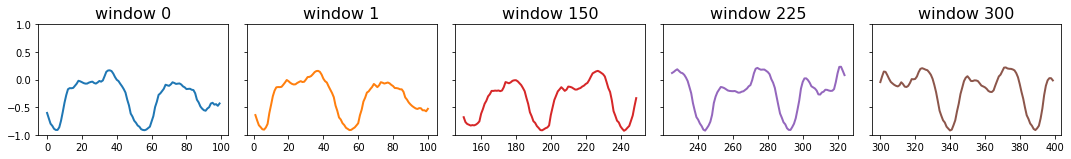

In [ ]:
# reconstruct
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)

To reassemble or “unroll” the predicted signal `X_hat` we can choose different aggregation methods (e.g., mean, max, etc). In our implementation, we chose it to as the median value.

<img src="https://github.com/signals-dev/Orion/blob/master/notebooks/tulog/images/reconstruct.png?raw=1" alt="Drawing" style="width: 1000px;"/>

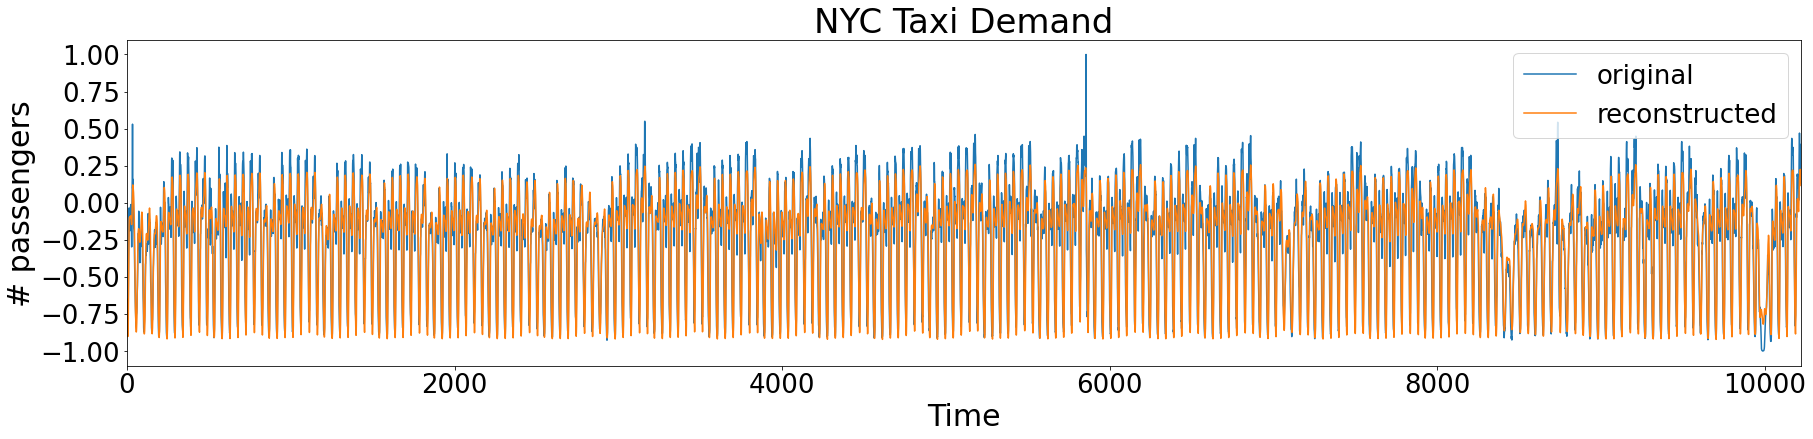

In [ ]:
# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

We can see that the GAN model did really well in trying to reconstruct the signal. We also see how it expected the signal to be, in comparison to what it actually is. The discrepancies between the two signals will be used to calculate the error. The higher the error, the more likely it is an anomaly

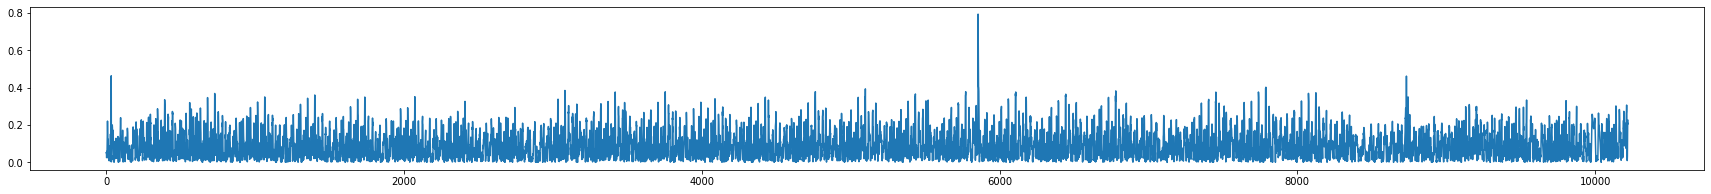

In [ ]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

### Error Computation

In the `TadGAN` pipeline, we use `tadgan.score_anomalies` to perform error calculation for us. It is a smoothed error function that uses a window based method to smooth the curve then uses either: area, point difference, or dtw as a measure of discrepancy. 

#### Area
This method captures the general shape of the orignal and reconstructed signal and then compares them together. 

<img src="https://github.com/signals-dev/Orion/blob/master/notebooks/tulog/images/area.png?raw=1" alt="Drawing" width="300"/>

#### Point
This method applies a point-to-point comparison between the original and reconstructed signal. It is considered a strict approach that does not allow for many mistakes.

<img src="https://github.com/signals-dev/Orion/blob/master/notebooks/tulog/images/point.png?raw=1" alt="Drawing" width="180"/>

#### DTW
A more lenient method yet very effective is Dynamic Time Warping (DTW). It compares two signals together using any pair-wise distance measure but it allows for one signal to be lagging behind another.

<img src="https://github.com/signals-dev/Orion/blob/master/notebooks/tulog/images/dtw.png?raw=1" alt="Drawing" width="400"/>

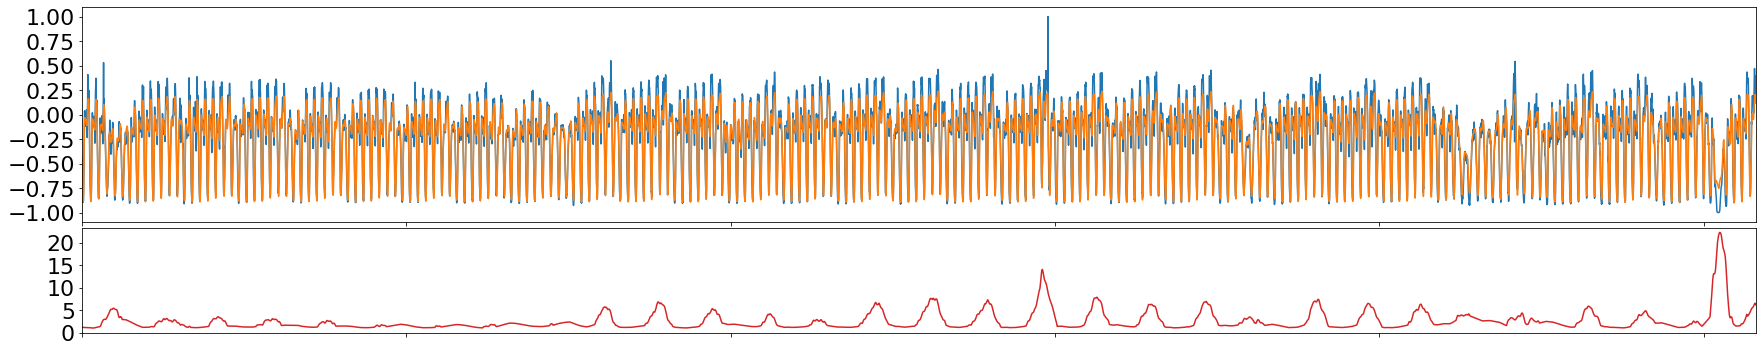

In [ ]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

Now we can visually see where the error reaches a substantially high value. But how should we decide if the error value determines a potential anomaly? We could use a fixed threshold that says if `error > 10` then let’s classify the datapoint as anomalous. 

In [ ]:
# threshold
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

[(1414798200, 1414877400, 12.026728174648975),
 (1422257400, 1422424800, 17.246974590142738)]

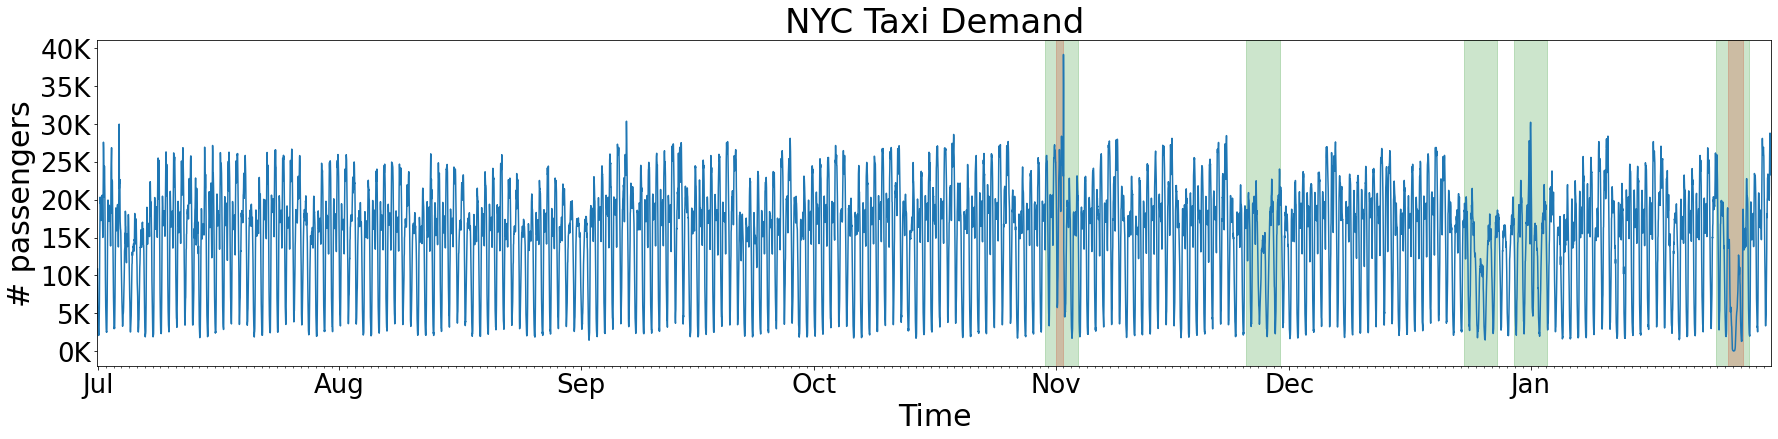

In [ ]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

While a fixed threshold raised two correct anomalies, it missed out on the other three. If we were to look back at the error plot, we notice that some deviations are abnormal within its local region. So how can we incorporate this information in our thresholding technique? We can use window based methods to detect anomalies with respect to their context.

We first define the window of errors, that we want to analyze. We then find the anomalous
sequences in that window by looking at the mean and standard deviation of the errors in the window.
We store the start/stop index pairs that correspond to each sequence, along with its score. 
We then move the window and repeat the procedure.
Lastly, we combine overlapping or consecutive sequences.

In [ ]:
from orion.primitives.timeseries_anomalies import find_anomalies

# find anomalies
intervals = find_anomalies(error, index, 
                           window_size_portion=0.33, 
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals

array([[1.40441940e+09, 1.40461560e+09, 4.18395064e-02],
       [1.40985900e+09, 1.41008400e+09, 1.41144854e-01],
       [1.41045120e+09, 1.41072120e+09, 2.67147421e-01],
       [1.41471360e+09, 1.41495660e+09, 5.13926798e-01],
       [1.42220700e+09, 1.42250040e+09, 1.27265042e+00]])

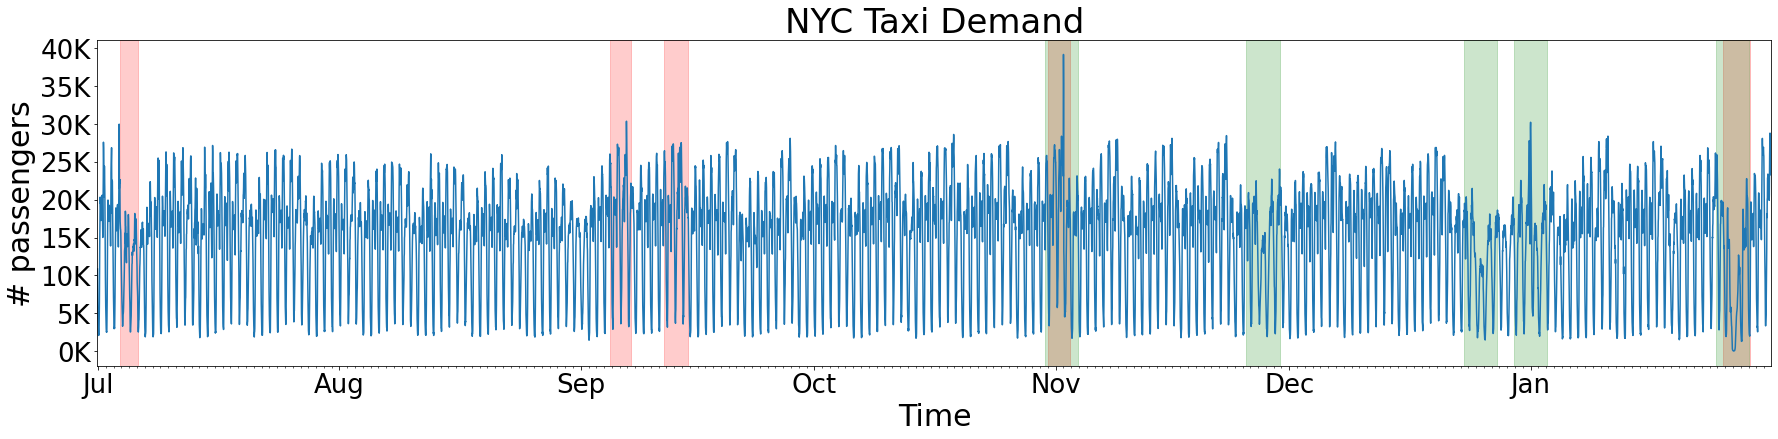

In [ ]:
# visualize the result
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])